# **1. Введение в fast.ai**

По материалам курсов https://course.fast.ai/

Главный автор фреймворка **fast.ai** -- **Jeremy Howard**. Его стартап Enlitic первым в мире применил технологии глубокого обучения в медицине, и вошёл в top-50 умнейших компаний мира по оценке MIT Tech Review.
Howard несколько лет возглавлял крупнейший портал по машинному обучению Kaggle, был также ведущим научным специалистом Kaggle и не раз побеждал в соревнованиях.

Его помощница **Rachel Thomas** была признана Forbes одной из 20 самых крутых женщин мира в сфере AI.

---

*переведено, дополнено, адаптировано, расширено https://vk.com/lambda_brain*
*январь 2020*

---

Дискламер: прохождение данного ноутбука не требует дополнительных знаний, хотя подразумевает элементарные представления о работе фреймворков машинного обучения. Но настоятельно рекомендуется пройти восемь ноутбуков базового курса по PyTorch, чтобы освоиться с терминологией и получить немного более глубокое понимание механизмов глубокого обучения.




# Занятие 1. Распознаём породы котиков и пёсиков



В этом занятии мы познакомимся на практике с фреймворком **fast.ai**.
Он настолько удобен и прост, что мы сразу возьмёмся за довольно сложную задачу классификации изображений (37 похожих категорий пород собак и кошек), и быстро получим качественные результаты.

*Несколько типовых строк общих настроек ноутбука (библиотеки перезагружаются автоматически, отображение графиков и изображений выполняется в коде ноутбука).*


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Библиотека **fast.ai** состоит из четырёх прикладных модулей (блок `applications`). 

Модуль `text` отвечает за работу с текстовыми данными (NLP + ULMFiT).

Модуль `tabular` отвечает за работу со структурированными данными.

Модуль `vision` отвечает за работу с изображениями. Он нам в данном занятии и нужен. Импортируем из него все возможности.

В блок `core` входит, в частности, модуль `metrics`, включающий функции, предназначенные для получения различных характеристик тензоров.


In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

Если вы запускаете ноутбук на слабом компьютере с небольшим объёмом ОЗУ, раскомментируйте вторую строчку. Она задаёт меньший размер пакета.

In [0]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after Restart

## Грузим данные

Будем использовать датасет [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) , в котором 37 категорий изображений: 12 пород котиков и 25 пород собачек (в каждой в среднем 200 изображений).

В работе [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf) в 2012-м удалось достичь точности 59.21%, используя весьма сложную модель, обученную например выделять "голову" и "туловище" животных. Посмотрим, что покажут PyTorch + fast.ai.

В блоке `core` имеется модуль `datasets`, предоставляющий простой доступ к ряду популярных датасетов. Для этого используется класс `URLs`, содержащий ряд констант -- веб-адресов соответствующих данных для прямого скачивания. В нашем случае будем использовать `URLs.PETS` (прямая ссылка на оксфордский набор).

Список всех датасетов:
https://docs.fast.ai/datasets.html#datasets

Удобная функция `untar_data` скачает и распакует датасет, заданный URL-ом. Она умная -- если данные уже были скачаны, повторной загрузки не произойдёт.
Возвращает эта функция путь к локальным данным в формате PosixPath. Её параметр dest позволяет явно задать локальный каталог загрузки.

In [4]:
path = untar_data(URLs.PETS) # скачиваем локально нужный датасет

Посмотрим, куда наш датасет загрузился по умолчанию, и что он вообще из себя представляет (как с ним работать, какого формата и размеров изображения, что из себя представляют метки):

In [5]:
path.ls()

[PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images')]

Как правило, определённые проблемы обычно вызывает формат датасета, способо хранения меток и т. п., на что нету единого стандарта. 

В этом конкретном наборе данных метки хранятся по сути как имена файлов -- названия конкретной породы и порядковый номер изображения внутри этой породы. Нам нужно будет извлечь их для последующей классификации изображений.



In [0]:
!ls /root/.fastai/data/oxford-iiit-pet/images

Хотя единого стандарта тут нет, но всё же создатели датасетов стараются придерживаться каких-то общепринятых подходов к их описанию. Вот и данный способ достаточно популярен, и в **fast.ai** имеется готовая функция `ImageDataBunch.from_name_re`, которая выделяет метки из имён файлов на основе шаблона в виде регулярного выражения.


In [0]:
path_anno = path/'annotations'
path_img = path/'images'

In [0]:
fnames = get_image_files(path_img)
fnames[:5]

In [0]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

In [0]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs
                                  ).normalize(imagenet_stats)

Параметр `size` -- это размер в пикселах, до которого изображения будут смасштабированы на лету. От этого размера достаточно сильно зависит и качество классификации, и потребляемые ресурсы.

Результат работы этой функции -- наш готовый для обработки датасет, или блок данных, тип `DataBunch` (точнее, его наследник `ImageDataBunch`), который содержит удобные методы работы с данными. В частности, для датасета изображений доступна простая функция быстрой визуализации содержимого `show_batch`. 

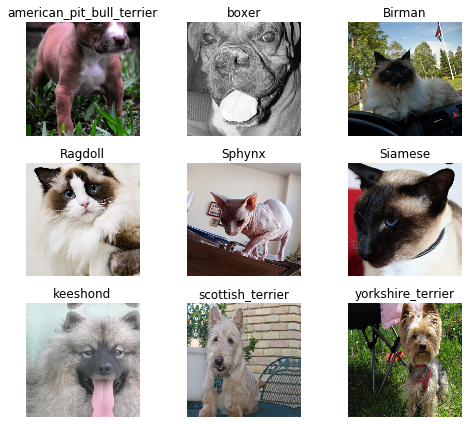

In [11]:
data.show_batch(rows=3, figsize=(7,6))

Атрибут classes блока данных содержит список всех выделенных классов изображений. Проверим заодно его длину, действительно ли в датасете 37 категорий.

In [12]:
print(data.classes)
len(data.classes)

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


37

## Начинаем обучение: resnet34

Для обучения нашей модели будем использовать [свёрточную нейронную сеть CNN --  convolutional neural network](https://neurohive.io/ru/vidy-nejrosetej/resnet-34-50-101/), а именно её конкретную реализацию **resnet34**, достаточно простую.  В нашем случае она должна иметь 37 выходов.

В модуле `vision.learner` определён метод `cnn_learner()`, который предназначен для простого использования предобученных моделей (transfer learning), что мы изучали в седьмом занятии базового курса. 

Документация: https://docs.fast.ai/vision.learner.html#Transfer-learning

Аргументы `cnn_learner` очень просты: это наш блок данных и идентификатор предобученной модели, которую мы хотим задействовать (из модуля `vision.models`). В нашем случае это будет `models.resnet34`.

Для нагладной визуализации процесса обучения можно указать метрики, которые **fast.ai** будет отслеживать. Эти метрики задаются в дополнительном параметре `metrics`.

Допустимые значения метрик описаны в модуле `metrics`:
https://docs.fast.ai/metrics.html#metrics


In [13]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate) # скачиваем выбранную предобученную модель

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 106MB/s] 


Метод `cnn_learner` скачивает предобученную модель, создаёт и возвращает объект класса `Learner` (базовый класс обучения, реализующий алгоритмы минимизации лосса с заданным оптимизатором). 

https://docs.fast.ai/basic_train.html#Learner

Можно посмотреть структуру этой модели:

In [0]:
learn.model

Наконец приступим к самому обучению. Тут используются два метода: универсальный `fit` на заданное количество эпох, и `fit_one_cycle`, который подразумевает предварительное определение границ коэффициента скорости обучения и его варьирование в этом диапазоне (Leslie Smith's 1cycle policy), подробнее см:

https://docs.fast.ai/callbacks.one_cycle.html#What-is-1cycle?

https://habr.com/ru/post/469931/

Четыре рекомендованные шага обучения в режиме 1cycle займут единичные минуты на типовой виртуалке Google Colab.

Сам процесс обучения модели хорошо визуализируется в реальном времени: наглядно понятно, сколько ещё примерно ожидать результата.

In [14]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,error_rate,time
0,1.120657,0.341890,0.098106,01:26
1,0.505808,0.274309,0.082544,01:25


В завершение сохраним нашу обученную модель:

In [0]:
learn.save('stage-1')
# learn.load('stage-1') # загрузка для наглядности

## Результаты

По какой схеме правильнее анализировать результаты обучения?

Прежде всего надо убедиться, что модель работает разумно -- она не путает совсем уж непохожие категории, а если и ошибается, то достаточно "естественно", на схожих изображениях. Это будет основной показатель, что модель выбрана в целом корректно.

Удобный способ подобной проверки -- построить матрицу ошибок (confusion matrix), для чего задействуем класс `ClassificationInterpretation`.

In [0]:
# создаём матрицу ошибок по нашей модели
interp = ClassificationInterpretation.from_learner(learn)

# упорядочиваем по убыванию (по умолчанию) лоссы и их индексы
losses, idxs = interp.top_losses() 

# удостоверяемся, что кол-во лоссов совпадает с размером проверочной выборки
len(data.valid_ds) == len(losses) == len(idxs) 

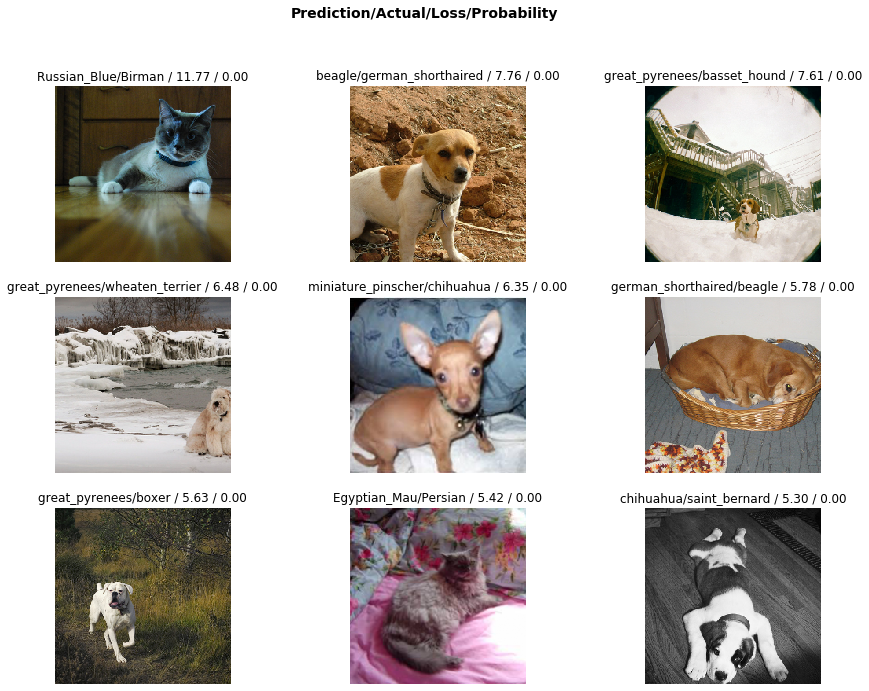

In [0]:
interp.plot_top_losses(9, figsize=(15,11)) # визуализируем 9 самых грубых ошибок

Действительно, британскую и бирманскую породы кошек при разном освещении вполне можно спутать, и маленькую чихуахуа с карликовым пинчером, и т. п.

Теперь выведем и изучим саму матрицу ошибок.

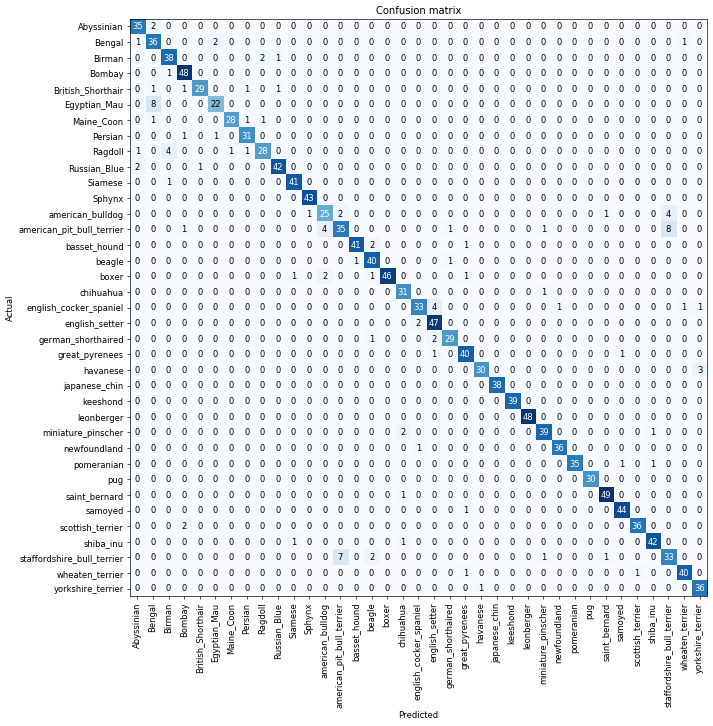

In [0]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

В частности, видны ошибки при классификации питбультерьеров и бульдогов, что тоже напоминает человеческую ошибку в отношении этих похожих пород. 

Быстро выявить крупнейшие отклонения в матрице ошибок (не попавшие на диагональ) можно с помощью метода `most_confused()`, параметр которого min_val задаёт минимальный порог ошибочных классификаций.

In [0]:
interp.most_confused(min_val=3)

## Разморозка, fine tuning и скорости обучения

Итак, наша модель работает примерно так, как и ожидалось, и теперь мы *разморозим* её (сделаем обучаемым каждый слой без исключения) и продолжим обучение.

Подробнее про разморозку, fine tuning и discriminative learning rates

https://mc.ai/fast-ai-lesson-5-notes-part-1/

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.696657,0.386763,0.125846,01:18


Особого качества в сравнении с оригинальной замороженной моделью не заметно.

Но теперь мы применим полноценную схему обучения 1cycle. Для этого надо выяснить зависимость лосса от скорости обучения, чтобы подобрать подходящий диапазон варьирования этой скорости. Такую зависимость строит метод `lr_find()` нашей модели.



In [0]:
learn.load('stage-1') # загрузим модель заново

In [0]:
learn.lr_find() # построим зависимость лосс - скорость обучения

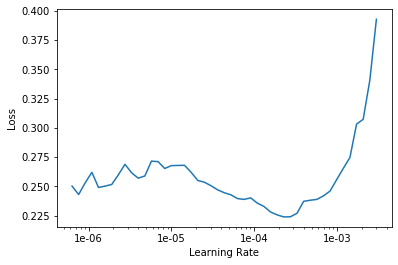

In [0]:
learn.recorder.plot() # визуализируем зависимость

Видно, что где-то после 1e-03 лосс начинает стремительно ухудшаться, поэтому ограничимся диапазоном до 1e-04.

In [0]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4)) # выполняем 1cycle в заданном диапазоне lr

epoch,train_loss,valid_loss,error_rate,time
0,0.236051,0.232650,0.071042,01:19
1,0.213178,0.226549,0.065629,01:19


Точность достигнута в разы лучше!

## Продолжаем эксперимент: модель resnet50

Далее задействуем для опытов более мощную модель **resnet50** -- в ней 50 слоёв, и в целом она более мощная, но и ресурсов потребует побольше.

Для повышения качества распознавания мы увеличим размеры изображений до 299 пикселов (многие оригинальные изображения значительно больше), но в два раза снизим размер пакета. 


Мы уже познакомились с базовыми возможностями **fast.ai**. С их помощью начать использовать в работе одну из стандартных моделей можно очень быстро, буквально за три шага.

In [0]:
# 1. создаём датасет в формате fast.ai
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=299, bs=bs//2).normalize(imagenet_stats)

In [0]:
# 2. загружаем нужную модель
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


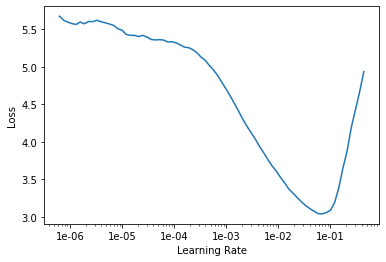

In [0]:
# необязательный шаг, если хотим применять схему 1cycle
learn.lr_find()
learn.recorder.plot()

In [0]:
# 3. выполняем обучение модели (порядка 10-15 минут)
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,0.756688,0.309136,0.098106,01:54
1,0.505356,0.237623,0.079161,01:54
2,0.453537,0.200364,0.068336,01:53
3,0.324153,0.225303,0.070365,01:54
4,0.281910,0.172078,0.058863,01:54
5,0.186244,0.159137,0.053451,01:52
6,0.144309,0.148645,0.050744,01:49
7,0.116816,0.144964,0.051421,01:48


In [0]:
learn.save('stage-1-50')

Это просто невероятная точность для такой довольно сложной задачки!

Давайте посмотрим, как будет работать обучение всей модели по схеме 1cycle:

In [0]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.116193,0.159562,0.050068,01:53
1,0.110625,0.145733,0.050744,01:52
2,0.081082,0.140448,0.048038,01:52


Получилось ещё точнее и быстрее. Но если этот вариант не устраивает, вернёмся обратно, и посмотрим самые грубые погрешности через матрицу ошибок.

In [0]:
learn.load('stage-1-50');

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

In [0]:
interp.most_confused(min_val=3)

[('Bengal', 'Egyptian_Mau', 6),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 6),
 ('Birman', 'Ragdoll', 5),
 ('Egyptian_Mau', 'Bengal', 4),
 ('Russian_Blue', 'British_Shorthair', 4),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 4),
 ('miniature_pinscher', 'chihuahua', 4)]

## Поработаем с другим стандартным датасетом

Давайте теперь вернёмся к классической задачке распознавания рукописных цифр, которую мы уже делали на чистом PyTorch, и сравним, насколько проще она будет решаться на **fast.ai**.

Данный датасет MNIST в этом фреймворке тоже определён как стандартный, загрузим его.

In [16]:
path = untar_data(URLs.MNIST_SAMPLE)

In [18]:
path.ls()

[PosixPath('/root/.fastai/data/mnist_sample/valid'),
 PosixPath('/root/.fastai/data/mnist_sample/train'),
 PosixPath('/root/.fastai/data/mnist_sample/labels.csv')]

Структура данного датасета, вполне предсказуемо, отличается от структуры оксфордского датасета PETS. 

**fast.ai** умеет работать с каталогом, содержащим подкаталоги train, valid и test (так называемый формат ImageNet). Для этого предлагается метод `from_folder`, которому указывается корневой каталог для исходных данных с такой структурой.

В оригинальной документации **fast.ai** дополнительно рекомендуется задать преобразование изображений: отключить их переворот с помощью `get_transforms(do_flip=False)`. Однако, вероятно, можно обойтись без него.


In [0]:
tfms = get_transforms(do_flip=False)
# data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=26)
data = ImageDataBunch.from_folder(path, size=28)

Как узнать, какие преобразования исходных изображений нужны? Прежде всего, визуально оценим изображения, насколько они "адекватны". 


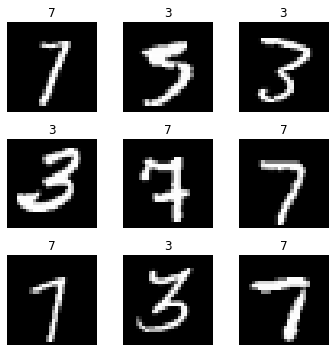

In [0]:
data.show_batch(rows=3, figsize=(5,5))

Возможно, под необходимостью поворота **fast.ai** подразумевал какую-то техническую особенность (потому что нейронной сети, строго говоря, всё равно, повёрнуты изображения, или нет).

Загрузим модель Resnet18 и сразу начнём её обучать стандартным методом fit() с количеством эпох, выводя метрику точности обучения.

In [0]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)
learn.fit(2)

Выведем шесть самых "грубых" ошибок модели.

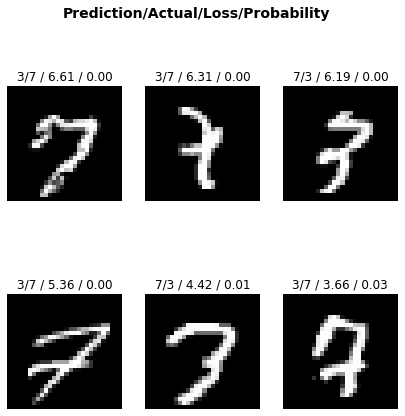

In [0]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(6, figsize=(7,7))

Как видно, в таких случаях и человеку ошибиться немудрено.

## Разные способы загрузки датасетов

Мы выше видели, что внутри датасета MNIST помимо "стандартных" каталогов train и valid имеется файл `labels.csv`, который, можно предположить, как-то описывает разметку датасета. Давайте заглянем в него.

In [0]:
# для чтения файла используем библиотеку pandas
df = pd.read_csv(path/'labels.csv')
df.head()

,name,label
0,train/3/7463.png,0
1,train/3/21102.png,0
2,train/3/31559.png,0
3,train/3/46882.png,0
4,train/3/26209.png,0


**fast.ai** содержит весьма мощные методы загрузки датасетов во всевозможных внешних форматах, и в частности предлагает `from_csv()`, когда данные берутся уже в соответствии с их минимальным мета-описанием (например, как изображения с метками разбиты на подкаталоги) в формате csv. Это конечно более предпочтительный способ.

In [0]:
data = ImageDataBunch.from_csv(path, ds_tfms=tfms, size=28)

[0, 1]

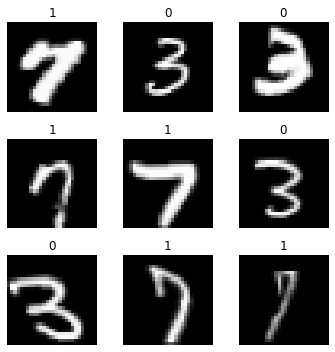

In [0]:
data.show_batch(rows=3, figsize=(5,5))
data.classes

Ещё один схожий вариант -- использовать вместо файла структуру в формате `DataFrame` из `pandas`.

In [0]:
data = ImageDataBunch.from_df(path, df, ds_tfms=tfms, size=24)
data.classes

[0, 1]

Способ выбора файлов и меток по регулярному выражению уже использовался в самом первом примере.

In [0]:
fn_paths = [path/name for name in df['name']]; fn_paths[:2]

[PosixPath('/root/.fastai/data/mnist_sample/train/3/7463.png'),
 PosixPath('/root/.fastai/data/mnist_sample/train/3/21102.png')]

In [0]:
pat = r"/(\d)/\d+\.png$"
data = ImageDataBunch.from_name_re(path, fn_paths, pat=pat, ds_tfms=tfms, size=24)
data.classes

['3', '7']

Ещё более гибкий способ -- указать функцию, которая будет формировать метки из имени файла.

In [0]:
data = ImageDataBunch.from_name_func(path, fn_paths, ds_tfms=tfms, size=24,
        label_func = lambda x: '3' if '/3/' in str(x) else '7')
data.classes

['3', '7']

In [0]:
labels = [('3' if '/3/' in str(x) else '7') for x in fn_paths]
labels[:5]

['3', '3', '3', '3', '3']

Наконец, способ в лоб -- использовать список файлов.


In [0]:
data = ImageDataBunch.from_lists(path, fn_paths, labels=labels, ds_tfms=tfms, size=24)
data.classes

['3', '7']

## Задание

Выясните, какие ещё стандартные датасеты с изображениями имеются в **fast.ai**, и подготовьте ноутбук, в котором выполняется (до)обучение подходящей модели до хорошего качества.

Попробуйте разобраться с freeze, fine tuning и discriminative learning rates, 
поэкспериментируйте с классическим fit() и с подходом 1cycle, и напишите комментарий по этим темам.

MY HOME WORK:

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate
bs = 64 #size packet
path = untar_data(URLs.PETS) # скачиваем локально нужный датасет
path.ls() # смотрим путь куда скачался датасет.


In [0]:
path_anno = path/'annotations'
path_img = path/'images'
fnames = get_image_files(path_img)
fnames[:5]
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'
#функция ImageDataBunch.from_name_re, которая выделяет метки из имён файлов на основе шаблона в виде регулярного выражения.
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs
                                  ).normalize(imagenet_stats) 
#size -- это размер в пикселах, до которого изображения будут смасштабированы на лету
#Результат работы этой функции -- наш готовый для обработки датасет, или блок данных, тип DataBunch (точнее, его наследник ImageDataBunch)
data.show_batch(rows=3, figsize=(7,6)) #смотрим что в итоге скачалось

print(data.classes) #Атрибут classes блока данных содержит список всех выделенных классов изображений
len(data.classes) # Проверяем длину блока данных (должно быть 37 категорий)

#Аргументы cnn_learner: это наш блок данных и идентификатор предобученной модели, которую мы хотим задействовать (из модуля vision.models). В нашем случае это будет models.resnet34
learn = cnn_learner(data, models.resnet34, metrics=error_rate) # скачиваем выбранную предобученную модель. Возвращает объект класса Learner (базовый класс обучения, реализующий алгоритмы минимизации лосса с заданным оптимизатором)
learn.model # смотрим структуру модели

#Обучение.
#используются два метода: универсальный fit на заданное количество эпох, и fit_one_cycle, который подразумевает предварительное определение границ коэффициента скорости обучения.
learn.fit_one_cycle(4)

learn.save('stage-1') #сохраняем обученную модель

#Анализ результатов.
# создаём матрицу ошибок по нашей модели
interp = ClassificationInterpretation.from_learner(learn)

# упорядочиваем по убыванию (по умолчанию) лоссы и их индексы
losses, idxs = interp.top_losses() 

# удостоверяемся, что кол-во лоссов совпадает с размером проверочной выборки
len(data.valid_ds) == len(losses) == len(idxs) 
interp.plot_top_losses(9, figsize=(15,11)) # визуализируем 9 самых грубых ошибок

interp.plot_confusion_matrix(figsize=(12,12), dpi=60) #Теперь выведем и изучим саму матрицу ошибок.
interp.most_confused(min_val=3)#Быстро выявить крупнейшие отклонения в матрице ошибок (не попавшие на диагональ).

#Разморозка модели (сделаем обучаемым каждый слой без исключения) и продолжим обучение.
learn.unfreeze()
learn.fit_one_cycle(1)

#Gрименим полноценную схему обучения 1cycle. Для этого надо выяснить зависимость лосса от скорости обучения, чтобы подобрать подходящий диапазон варьирования этой скорости. Такую зависимость строит метод lr_find() нашей модели.
learn.load('stage-1') # загрузим модель заново
learn.lr_find() # построим зависимость лосс - скорость обучения
learn.recorder.plot() # визуализируем зависимость

learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4)) # выполняем 1cycle в заданном диапазоне lr (который подобрали из графика зависимости лосс - скорость обучения)



Если выделить основные действия (на примере модели ResNet50) то получается вот так: 

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate
bs = 64 #size packet
path = untar_data(URLs.PETS) # скачиваем локально нужный датасет

In [0]:
# 1. создаём датасет в формате fast.ai
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=299, bs=bs//2).normalize(imagenet_stats)
# 2. загружаем нужную модель
learn = cnn_learner(data, models.resnet50, metrics=error_rate)
# 3. если хотим применять схему 1cycle
learn.lr_find()
learn.recorder.plot()
# 4. выполняем обучение модели (порядка 10-15 минут)
learn.fit_one_cycle(8)
learn.save('stage-1-50')
#Давайте посмотрим, как будет работать обучение всей модели по схеме 1cycle:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4)) #используем данные из графика с шага 3. 

#Если результаты не устроили, можно вернуться обратно, и посмотреть самые грубые погрешности через матрицу ошибок.
learn.load('stage-1-50')
interp = ClassificationInterpretation.from_learner(learn)
interp.most_confused(min_val=3)